## Angewandtes Quantencomputing – Laborpraktikum WiSe 25/26

### Musterlösung für Praktikum 8: Parametrisierte Quantenschaltkreise (28.11.2025)

In diesem Praktikum beschäftigen wir uns mit der Optimierung parametrisierter Quantenschaltkreise.  
Dazu implementieren wir zunächst einen parametrierten Quantenschaltkreis und berechnen Erwartungswerte mithilfe von Qiskit.

Im Anschluss minimieren wir den Erwartungswert mit einer ableitungsfreien Optimierungsmethode.

Im dritten Teil implementieren wir die Ableitungen parametrischer Quantenschaltkreise mittels Finite-Differenzen sowie der Parameter-Shift-Rule und vergleichen die beiden Verfahren.

Abschließend implementieren wir eine gradientenbasierte Optimierung des Erwartungswerts unter Verwendung der hergeleiteten Ableitungen.


In [1]:
import numpy as np
from typing import Union
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp

### Aufgabe 1: Bausteine

**Aufgabe 1.1:** Implementieren Sie eine Funktion, die einen parametri­sierten Quantenschaltkreis mit der folgenden Struktur erzeugt:

```python
     ┌───┐┌──────────┐                      ┌───┐
q_0: ┤ H ├┤ Ry(p[0]) ├──■───────────────────┤ X ├
     ├───┤├──────────┤┌─┴─┐                 └─┬─┘
q_1: ┤ H ├┤ Ry(p[1]) ├┤ X ├──■────────────────┼──
     ├───┤├──────────┤└───┘┌─┴─┐              │  
q_2: ┤ H ├┤ Ry(p[2]) ├─────┤ X ├─────■────────┼──
     ├───┤├──────────┤     └───┘   ┌─┴─┐      │  
q_3: ┤ H ├┤ Ry(p[3]) ├─────────────┤ X ├──────■──
     └───┘└──────────┘             └───┘         
          └─────────────────────────────────────┘
    num_layer-mal wiederholt mit unterschiedlichen Parametern
```

Die Funktion soll eine beliebige Anzahl von Qubits sowie eine vorgegebene Anzahl von Wiederholungen des Ry–CX-Blocks (`num_layer`) unterstützen.

**Hinweis:** Für das letzte CX Gatter können Sie die mod Funktion `%` verwenden: ``0 % 4 = 0, 1 % 4 = 1, 2 % 4 = 2, 3 % 4 = 3, 4 % 4 = 0, 5 % 4 = 1, ...``

In [2]:
def parametrized_circuit(num_qubits: int = 2, num_layers: int = 1) -> QuantumCircuit:
    """Creates a parameterized quantum circuit with the given number of qubits and layers.

    Args:
        num_qubits (int): Number of qubits in the circuit.
        num_layers (int): Number of layers (repetitions) in the circuit.

    Returns:
        QuantumCircuit: The constructed parameterized quantum circuit.
    """

    p = ParameterVector("p", length=num_layers * num_qubits * 2)
    quantum_circuit = QuantumCircuit(num_qubits)

    quantum_circuit.h(range(num_qubits))

    param_index = 0
    for layer in range(num_layers):
        for qubit in range(num_qubits):
            quantum_circuit.ry(p[param_index], qubit)
            param_index += 1
        for qubit in range(num_qubits):
            quantum_circuit.cx(qubit, (qubit + 1) % num_qubits)

    return quantum_circuit

Sie können ihre Funktion mit dem folgenden Code testen:

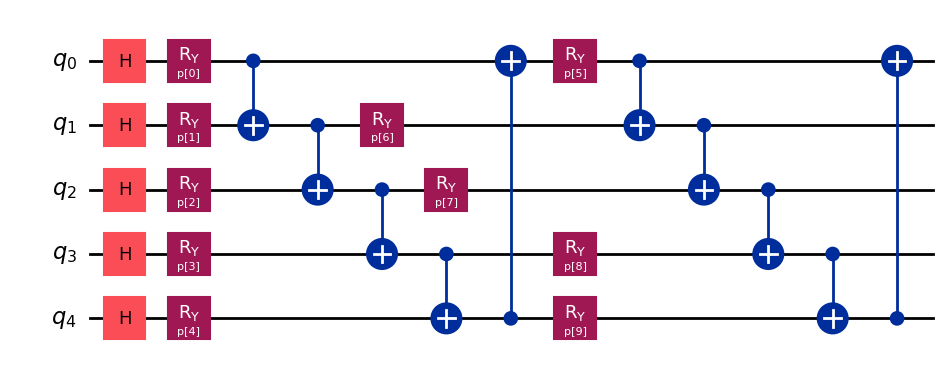

In [3]:
quantum_circuit = parametrized_circuit(num_qubits=5, num_layers=2)
quantum_circuit.draw("mpl")

**Aufgabe 1.2:** Berechnen Sie den theoretischen Erwartungswert mit dem Qiskit-Estimator.

Für die exakte Simulation des Erwartungswertes nutzen wir das von Qiskit bereitgestellte Primitive `StatevectorEstimator`.

Wie zuvor beim Sampler-Primitive müssen wir den Estimator zunächst initialisieren.  
Um eine Aufgabe an den Estimator zu senden, müssen wir ein Tupel `(..., ...)` bestehend aus 1. Schaltkreis, 2. Observable und 3. Parameterwerte formen.  

Dieses Tupel wird der `run`-Methode des initialisierten Estimators in einer Liste übergeben, also z.B.  
`estimator.run([(schaltkreis, observable, parameter)])`.  
Das Ergebnis kann anschließend mit der Methode `result()` abgerufen werden. Der Erwartungswert befindet sich dann in der Datenstruktur `result[0].data.evs`.

Zusammengefasst:

```python
estimator = StatevectorEstimator()
result = estimator.run([(pqc, observable, parameters)]).result()
float(result[0].data.evs)
```

Berechnen Sie den Erwartungswert für die in der nächsten Zelle gegebene Observable.
Nutzen Sie dafür die Funktion aus Aufgabe 1.1, um einen Schaltkreis mit 2 Qubits und 2 Layern zu erzeugen.
Die Werte für die Parameter werden zufällig in der nächsten Zelle generiert.  
Für diese Werte der Parameter erhalten Sie einen Erwartungswert von ungefähr $-1.05493392144$.

In [4]:
from qiskit.primitives import StatevectorEstimator

# Gegebener Observable für zwei Qubits:
observable = SparsePauliOp(
    data=["ZZ", "IZ", "ZI", "II", "XX", "YY"],
    coeffs=[
        0.0934565 + 0.0j, 0.0934565 + 0.0j, -0.03564482 + 0.0j, 
       -0.84457058 + 0.0j,-0.05738398 + 0.0j, -0.05738398 + 0.0j,
    ],
)

# Gegebener parametrisierter Schaltkreis mit zufälligen Parametern:
quantum_circuit = parametrized_circuit(num_qubits=2, num_layers=2)
np.random.seed(0)
parameters = np.random.rand(quantum_circuit.num_parameters)

In [5]:
estimator = StatevectorEstimator()
result = estimator.run([(quantum_circuit, observable, parameters)]).result()
float(result[0].data.evs)

-1.0549339214407079

**Aufgabe 1.3:** Als Nächstes implementieren wir die Berechnung des Erwartungswerts anhand einzelner Messungen in Qiskit.

Hierfür müssen wir lediglich die Initialisierung des Estimators anpassen.  
Wir verwenden den `EstimatorV2`-Primitive von Qiskit und initialisieren ihn mit einem Backend, das auf einem Simulator basiert.  
Die Anzahl der Messungen wird bei diesem Primitive über die Option `default_precision` festgelegt. Diese orientiert sich an der Standardabweichung des Erwartungswerts und kann über die Formel  $ 1 / \sqrt{N_{\text{shots}}} $  gesetzt werden.

Die Initialisierung des Estimators erfolgt mit:

```python
backend = Aer.get_backend('aer_simulator')
estimator = EstimatorV2(mode=backend, options={"default_precision": 1 / np.sqrt(shots)})
```
Die Berechnung des Erwartungswerts erfolgt anschließend identisch wie in Aufgabe 1.2.
Berechnen Sie den Erwartungswert für 1024 Shots.
Für die Parameter aus Aufgabe 1.2 sollten die Ergebnisse im Bereich zwischen etwa $1.048$ und $1.062$ liegen.

In [6]:
from qiskit_aer import Aer
from qiskit_ibm_runtime import EstimatorV2

In [7]:
shots = 1024

backend = Aer.get_backend("aer_simulator")
estimator = EstimatorV2(mode=backend, options={"default_precision": 1 / np.sqrt(shots)})

# Execute the quantum circuit with measurements
result = estimator.run([(quantum_circuit, observable, parameters)]).result()
float(result[0].data.evs)

-1.0579113296484375

**Aufgabe 1.4:** Zum Schluss berechnen wir den Erwartungswert auf einem simulierten Hardware-Backend (der Code für ein reales Backend ist derselbe – es muss nur das Backend ausgetauscht werden).

Die Initialisierung des Estimators funktioniert exakt wie in Aufgabe 1.3, nur dass wir statt des Simulators das Backend `FakeTorino()` verwenden.

In diesem Schritt müssen wir zusätzlich den Quantenschaltkreis transpilieren. Dies funktioniert auch, wenn der Schaltkreis Parameter enthält!  
Nutzen Sie dazu wie zuvor die Funktion `transpile`:

```python
transpiled_circuit = transpile(circuit, backend=FakeTorino())
```

Zusätzlich muss auch die Observable an den transpilierten Schaltkreis angepasst werden, da sich durch das Transpilieren die Zuordnung der Qubits ändern kann.
Dies kann mit dem folgenden Code umgesetzt werden:
```python
transpiled_observable = observable.apply_layout(transpiled_circuit.layout)
```

Alles andere funktioniert analog zu Aufgabe 1.3.
Berechnen Sie den Erwartungswert auf dem simulierten Backend `FakeTorino()` für 1024 Messungen (shots).
Für die Parameter aus Aufgabe 1.2 erwartet man Werte im Bereich von ungefähr $1.032$ bis $1.049$.

In [8]:
from qiskit_ibm_runtime.fake_provider import FakeTorino, FakeManilaV2
from qiskit.compiler import transpile

In [9]:
backend = FakeTorino()

num_shots = 1024

estimator = EstimatorV2(
    mode=backend, options={"default_precision": 1 / np.sqrt(num_shots)}
)

transpiled_circuit = transpile(quantum_circuit, backend=FakeTorino())
transpiled_observable = observable.apply_layout(transpiled_circuit.layout)

result = estimator.run(
    [(transpiled_circuit, transpiled_observable, parameters)]
).result()
print(float(result[0].data.evs))

-1.04780956171875


**Aufgabe 1.5:** Verpacken wir die Auswertung mit dem Qiskit-Estimator in eine einfache Funktion, die als Eingaben den Schaltkreis, die Observable, die Parameter, die Anzahl der Messungen (`shots`) und das Backend erhält.

- Für `shots is None` soll die exakte Simulation (wie in Aufgabe 1.2) verwendet werden.  
- Für `backend is None` und `shots is not None` soll die Simulation mit endlichen Messungen (wie in Aufgabe 1.3) genutzt werden.  
- Ist ein Backend gegeben (`backend is not None`), soll stattdessen der Estimator mit diesem Backend verwendet werden (wie in Aufgabe 1.4). Dabei dürfen Transpilierung des Schaltkreises und Anpassung der Observable nicht vergessen werden.

Implementieren Sie eine Funktion, die in allen drei Fällen den Erwartungswert als `float` zurückgibt.

In [10]:
from qiskit_aer import Aer


def evaluate_expectation_value(
    circuit: QuantumCircuit,
    observable: SparsePauliOp,
    parameters: np.array,
    shots: Union[None, int] = None,
    backend=None,
) -> float:
    """
    Evaluates the expectation value of the given observable with respect to the state prepared by the circuit with the specified parameters.

    Args:
        circuit: The parameterized quantum circuit.
        observable: The observable to measure.
        parameters: The parameters to bind to the circuit.
        shots: Number of shots for execution. If None, a statevector simulator is used.
        backend: The backend to use for execution. If None, perfect backend is used.

    Returns:
        float: The expectation value of the observable.

    """
    if shots is None:
        estimator = StatevectorEstimator()
        circuit_run = circuit
        observable_run = observable
    elif backend is None:
        backend = Aer.get_backend("aer_simulator")
        estimator = EstimatorV2(
            mode=backend, options={"default_precision": 1 / np.sqrt(shots)}
        )
        circuit_run = circuit
        observable_run = observable

    else:

        circuit_run = transpile(circuit, backend=backend)
        observable_run = observable.apply_layout(circuit_run.layout)

        estimator = EstimatorV2(
            mode=backend, options={"default_precision": 1 / np.sqrt(shots)}
        )

    result = estimator.run([(circuit_run, observable_run, parameters)]).result()
    return float(result[0].data.evs)

Testen Sie Ihre Implementierung mit den folgenden Funktionsaufrufen.  
Die Ergebnisse sollten jeweils im selben Wertebereich liegen wie in den Aufgaben 1.2 bis 1.4.


In [11]:
evaluate_expectation_value(
    quantum_circuit, observable, parameters, shots=None, backend=None
)

-1.0549339214407079

In [12]:
evaluate_expectation_value(
    quantum_circuit, observable, parameters, shots=1024, backend=None
)

-1.051108363046875

In [13]:
evaluate_expectation_value(
    quantum_circuit, observable, parameters, shots=1024, backend=FakeTorino()
)

-1.0493223691015625

Sie können den Code auch auf einem echten Quantencomputer ausprobieren (das dauert allerdings eine Weile, da wir in die Warteschlange müssen).

In [14]:
# from qiskit_ibm_runtime import QiskitRuntimeService

# # Verbinden mit der IBM Quantum Cloud
# service = QiskitRuntimeService(channel="ibm_cloud", token="TOKEN HIER EINFÜGEN")
# backend_torino = service.backend("ibm_torino")
# evaluate_expectation_value(pqc, observable, parameters, shots=1024, backend=backend_torino)

In [15]:
# Falls die Implementierung evaluate_expectation_value nicht funktioniert können Sie sie auch
# mit dem folgenden Code importieren und nutzen.

from qc_lecture_tools.expectation_value import evaluate_expectation_value

### Aufgabe 2: Optimierung des Erwartungswerts

In dieser Aufgabe minimieren wir den Erwartungswert für den in Aufgabe 1 implementierten parametrisierten Quantenschaltkreis.

Die Observable für 4 Qubits ist in der nächsten Zelle gegeben.

Nutzen Sie für die Optimierung die SciPy-Funktion  
`result_optimization = minimize(fun, x0, method)`  
mit den folgenden Argumenten:

- `fun`: Python-Funktion, die minimiert werden soll, in unserem Fall der Erwartungswert für gegebene Parameter.  
- `x0`: Initiale, zufällige Parameter.  
- `method`: Optimierungsmethode. Sie können hier den COBYLA-Optimierer verwenden, also `method="COBYLA"`.

Schreiben Sie eine Hilfsfunktion, die minimiert werden soll:

```python
def objective(parameters: np.ndarray) -> float:
    ...
    return expectation_value
```
Übergeben Sie diese Funktion zusammen mit den zufälligen Parametern und `method="COBYLA"` an `minimize`.  
`minimize` ruft die übergebene Funktion mehrfach auf und versucht, deren Wert zu minimieren.  
Wenn Sie beobachten möchten, was während der Optimierung passiert, können Sie den Erwartungswert innerhalb der Hilfsfunktion ausgeben.

`minimize` gibt ein Ergebnisobjekt zurück, das unter anderem die folgenden Attribute enthält:

- `result_optimization.x`: Optimierte Parameterwerte  
- `result_optimization.fun`: Minimaler Erwartungswert  
- `result_optimization.nfev`: Anzahl der Funktionsauswertungen

**Aufgabe 2.1:** Implementieren Sie die Optimierung für unterschiedliche Anzahlen von Wiederholungen (`num_layers = 1, 2, 3, 4`).  
Vergleichen Sie die minimalen Erwartungswerte mit dem kleinsten Eigenwert der Observable $ \lambda_{\min} $.  
Wie viele Wiederholungen werden im Schaltkreis benötigt, um sich diesem Wert anzunähern?


In [16]:
import numpy as np
from scipy.optimize import minimize

# Die gegebene Observable entspricht einem Quantenphysikalischen Models des H2 Molekül
# Der minimale Eigenwert entspricht dem Grundzustandsenergie des H2 Moleküls, was das genau Bedeutet behandeln wir später in der Vorlesung.
observable_h2 = SparsePauliOp(
    data=[
        "ZZIZ", "IZZI", "IIZI", "IIIZ", "IIII",
        "ZIZZ", "ZZZZ", "ZZII", "IZII", "IZZZ",
        "IIZZ", "IIII", "IIXX", "IZYY", "ZZYY",
        "ZIXX",
    ],
    coeffs=[
        0.0934565 + 0.0j, 0.0934565 + 0.0j, -0.03564482 + 0.0j, -0.03564482 + 0.0j, -0.84457058 + 0.0j,
        0.13817585 + 0.0j, 0.08253705 + 0.0j, 0.13992104 + 0.0j, 0.13992104 + 0.0j, 0.08253705 + 0.0j,
        0.14585519 + 0.0j, 0.35278481 + 0.0j, -0.05738398 + 0.0j, -0.05738398 + 0.0j, -0.05738398 + 0.0j,
        -0.05738398 + 0.0j,
    ],
)

In [17]:
# Kleinster Eigenwert der Observable
np.min(np.linalg.eigh(observable_h2.to_matrix()).eigenvalues)

np.float64(-0.9981493346131962)

In [18]:
num_layers = 3

# Parametrisierter Schaltkreis
quantum_circuit = parametrized_circuit(num_qubits=4, num_layers=num_layers)

# Startwerte für die Parameter
np.random.seed(0)
theta0 = np.random.rand(quantum_circuit.num_parameters)


def objective(parameters: np.ndarray) -> float:
    value = evaluate_expectation_value(quantum_circuit, observable_h2, parameters)
    print(value)
    return value


# Beispiel: Optimierung mit COBYLA
result_optimization = minimize(
    objective,
    x0=theta0,
    method="COBYLA",
)

print("COBYLA:")
print(" theta* =", result_optimization.x)
print(" f(theta*) =", result_optimization.fun)
print(" nfev =", result_optimization.nfev)

-0.5367703021521458
-0.5248758432549689
-0.5333636709656223
-0.5502769176816614
-0.5119705782303972
-0.5703626715722703
-0.41927308393497104
-0.37836176711186387
-0.5191826933592039
-0.5719276113171153
-0.41608016550830984
-0.5563197938479295
-0.5351371415934438
-0.6256527983846015
-0.520756230982447
-0.5770537973316211
-0.6482126961289759
-0.6068622718781733
-0.6702114912273538
-0.6632861436871824
-0.586040273351886
-0.7347877967819028
-0.7032254806475947
-0.6627672224583178
-0.6719684367573858
-0.7237685832310632
-0.790865834278311
-0.7241286150554933
-0.7411904244947677
-0.610253386494102
-0.8287039755268462
-0.8698062081095786
-0.8728496017842047
-0.9078226870654813
-0.8909882196262826
-0.8976218649120927
-0.8934402423096002
-0.8896505587822803
-0.8612351708400773
-0.8934665080016331
-0.8885976388689705
-0.8992588795778059
-0.8747555415970472
-0.9004603239465881
-0.9089944246910647
-0.9000639295213518
-0.910482727275358
-0.9089633096903891
-0.9085240577341561
-0.8934578133043158
-0

**Aufgabe 2.2:** Wiederholen Sie die Optimierung mit drei Wiederholungen (`num_layers = 3`) und verwenden Sie diesmal `10000` Messungen pro Erwartungswert.  
Was beobachten Sie im Vergleich zur exakten Simulation?

In [19]:
quantum_circuit = parametrized_circuit(num_qubits=4, num_layers=3)


# Startwerte für die Parameter
np.random.seed(0)
theta0 = np.random.rand(quantum_circuit.num_parameters)


def objective(parameters: np.ndarray) -> float:
    value = evaluate_expectation_value(
        quantum_circuit, observable_h2, parameters, shots=10000
    )
    print(value)
    return value


# Beispiel: Optimierung mit COBYLA
result_optimization = minimize(
    objective,
    x0=theta0,
    method="COBYLA",
)

print("COBYLA:")
print(" theta* =", result_optimization.x)
print(" f(theta*) =", result_optimization.fun)
print(" nfev =", result_optimization.nfev)

-0.53707737976
-0.52321693796
-0.5291795354479999
-0.5503487053039999
-0.5082497917199997
-0.575895636772
-0.41712799874
-0.37948341553599985
-0.51818594678
-0.5731173936519999
-0.4576905121439998
-0.5915808383719998
-0.5251074942520001
-0.6850874439560001
-0.6245629123359999
-0.7126147781479999
-0.6691839149320002
-0.66905217624
-0.6755984830959999
-0.644840947956
-0.6294096954919999
-0.7641059527399998
-0.7295643336239999
-0.754504963216
-0.7737723126599998
-0.7862112023639998
-0.75566780536
-0.7998734744119999
-0.82361121298
-0.8002289418399999
-0.820073885004
-0.8135645694639999
-0.8047452045159998
-0.818627627012
-0.811961928264
-0.77671748658
-0.817857776624
-0.8227607435840001
-0.8446413971439999
-0.8400419392920001
-0.8387785410999999
-0.836086744012
-0.8352885115439999
-0.8324365940999999
-0.8387071764159997
-0.841064350788
-0.8206377905879998
-0.830916554684
-0.8346277708440001
-0.8294502827280001
-0.8321812261919997
-0.8311846875439999
-0.8363217724080001
-0.8381118452279999

**Beobachtung:** Die Optimierung mit Messungen konvergiert nur sehr langsam und nicht stabil. 

### Aufgabe 3: Ableitungen

Bisher haben wir nur den Funktionswert $f(p_1, \dots, p_n)$ betrachtet.  
Für Optimierungsverfahren (insbesondere Gradientenverfahren) ist jedoch auch wichtig zu wissen: Wie stark ändert sich der Funktionswert, wenn ich einen Parameter ein kleines bisschen verändere?

Das ist genau die Idee der **Ableitung**.

Betrachten wir zuerst eine Funktion mit **nur einem Parameter**, z. B. $f(p)$.

- Der Wert $f(p)$ sagt: Wie hoch ist der Funktionswert an der Stelle $p$?  
- Die **Ableitung** $f'(p)$ sagt: Wie steil geht die Funktion an der Stelle $p$ nach oben oder unten?

Graphisch kann man sich das so vorstellen:

- $f'(p) > 0$ → die Kurve steigt (es geht bergauf).  
- $f'(p) < 0$ → die Kurve fällt (es geht bergab).  
- $f'(p) = 0$ → waagerechte Tangente (Plateau, Maximum oder Minimum).

Numerisch kann man die Ableitung in einer Dimension zum Beispiel mit der **zentralen Differenz** approximieren:

$$
f'(p) \approx \frac{f(p + h) - f(p - h)}{2h}
$$

Je kleiner $h$ ist, desto besser wird diese Approximation (theoretisch wird sie im Limes $h \to 0$ exakt).

In unseren Optimierungsproblemen haben wir nicht nur einen Parameter, sondern **viele**:

$$
p = (p_1, p_2, \dots, p_n)
$$

Die Funktion $f$ hängt also von allen diesen Parametern ab:

$$
f(p_1, p_2, \dots, p_n)
$$

Wir können nun für **jeden einzelnen Parameter** $p_i$ fragen: Wie ändert sich $f$, wenn ich **nur** $p_i$ ein bisschen verändere und alle anderen Parameter festhalte?

Das ist die **partielle Ableitung**:

$$
\frac{\partial}{\partial p_i} f(p_1, p_2, \dots, p_n)
$$

Der **Gradient** fasst alle partiellen Ableitungen in einem Vektor zusammen:

$$
\nabla f(p_1,p_2,\dots,p_n) =
\begin{pmatrix}
\frac{\partial}{\partial p_1} f \\
\frac{\partial}{\partial p_2} f \\
\vdots \\
\frac{\partial}{\partial p_n} f
\end{pmatrix}
$$

Der Gradient ist also der Vektor aller Ableitungen nach den Parametern.

Wichtig für die Optimierung:

- Der Gradient zeigt in die Richtung des **stärksten Anstiegs** von $f$.  
- Beim Minimieren gehen wir in die **entgegengesetzte Richtung**, also in Richtung $-\nabla f$.


Die einzelnen partiellen Ableitungen können wir numerisch approximieren mit **finiten Differenzen**.

Für einen bestimmten Parameter $p_i$ verwenden wir wieder die zentrale Differenz:

$$
\frac{\partial}{\partial p_i} f(p_1,p_2,\ldots,p_i,\ldots,p_n) 
\approx 
\dfrac{
f(p_1,p_2,\ldots, p_i + h, \ldots, p_n) -
f(p_1,p_2,\ldots, p_i - h, \ldots, p_n)
}{2h}
$$

Interpretation:

1. Wir starten beim aktuellen Parametervektor  
   $p = (p_1, \dots, p_i, \dots, p_n)$.
2. Wir bilden zwei leicht veränderte Versionen:
   - $p^{+}$: wie $p$, aber mit $p_i \to p_i + h$  
   - $p^{-}$: wie $p$, aber mit $p_i \to p_i - h$
3. Wir berechnen die Funktionswerte $f(p^{+})$ und $f(p^{-})$.  
4. Wir setzen diese Werte in die Differenzenformel ein.

Für $h \to 0$ konvergiert diese Approximation gegen die exakte partielle Ableitung.  
In der Praxis wählen wir ein kleines, aber festes $h$ (z. B. $h = 0.01$).

---

**Aufgabe 3.1:** Wir nutzen die zentrale Differenzenformel, um die Ableitungen zu approximieren.  
Implementieren Sie die Berechnung des Gradienten unseres Erwartungswerts mittels finiter Differenzen.

Skizze der Implementierung:

- Erzeugen Sie eine leere Liste `gradient = []`.
- Für jeden Parameter $p_i$ (For-Schleife über die Indizes):
  - Erzeugen Sie Kopien des aktuellen Parametervektors mit `parameters_plus = parameters.copy()` und `parameters_minus = parameters.copy()`.
  - Verändern Sie nur den Eintrag am Index `i` mit plus und minus h. 
  - Berechnen Sie $f(p^{+})$ und $f(p^{-})$ mit der Funktion `evaluate_expectation_value`.
  - Bestimmen Sie daraus die approximierte partielle Ableitung:
    $$
    (\nabla f)_i \approx \frac{f(p^{+}) - f(p^{-})}{2h}
    $$
  - Fügen Sie diesen Wert mit `gradient.append(value)` der Liste `gradient` hinzu.

Die Liste `gradient` (z. B. später in ein `np.array` umgewandelt) ist dann der numerisch approximierte Gradient für die aktuellen Parameter `parameters`.


In [20]:
def gradient_finite_differences(
    quantum_circuit: QuantumCircuit,
    observable: SparsePauliOp,
    parameters: np.ndarray,
    delta_h: float = 0.01,
    shots: Union[int, None] = None,
    backend=None,
) -> np.array:
    """Computes the gradient of the expectation value function using finite differences.

    Args:
        quantum_circuit (QuantumCircuit): The parameterized quantum circuit.
        observable (SparsePauliOp): The observable for which the expectation value is computed.
        parameters (np.ndarray): The current parameters of the quantum circuit.
        delta_h (float): The small perturbation used for finite differences.
        shots (Union[int, None]): Number of shots for measurement. If None, statevector simulation is used.
        backend: The backend to use for execution. If None, perfect backend is used.

    Returns:
        np.array: The gradient vector of the expectation value with respect to the parameters.
    """

    gradient = []

    for p in range(len(parameters)):
        params_plus = parameters.copy()
        params_plus[p] += delta_h
        exp_plus = evaluate_expectation_value(
            quantum_circuit, observable, params_plus, backend=backend, shots=shots
        )

        params_minus = parameters.copy()
        params_minus[p] -= delta_h
        exp_minus = evaluate_expectation_value(
            quantum_circuit, observable, params_minus, backend=backend, shots=shots
        )

        gradient.append((exp_plus - exp_minus) / (2 * delta_h))

    return np.array(gradient)

Sie können Ihre Implementierung mit dem folgenden Code testen.  
Das Ergebnis sollte ungefähr

`array([-0.13663224, -0.02733412])`

sein.


In [21]:
# Observable zum testen
observable = SparsePauliOp(
    data=["ZZ", "IZ", "ZI", "II", "XX", "YY"],
    coeffs=[
        0.0934565 + 0.0j, 0.0934565 + 0.0j, -0.03564482 + 0.0j, 
       -0.84457058 + 0.0j,-0.05738398 + 0.0j, -0.05738398 + 0.0j,
    ],
)

# Parametrisierter Schaltkreis zum testen
quantum_circuit = parametrized_circuit(num_qubits=2, num_layers=1)

# Zufällige Parameter zum testen
np.random.seed(0)
theta0 = np.random.rand(quantum_circuit.num_parameters)

gradient_finite_differences(quantum_circuit, observable, theta0)

array([-0.13663224, -0.02733412])

**Aufgabe 3.2:** Implementierung der Ableitung mit der Parameter-Shift-Rule

In vielen quantenmechanischen Modellen (z. B. in variationalen Quantenalgorithmen) können Ableitungen nicht mit klassischen finiten Differenzen berechnet werden.  
Stattdessen nutzt man die **Parameter-Shift-Rule**, eine exakte Formel für die Ableitung eines parametrisierten Quantenschaltkreises.

Für einen Parameter $p_i$ gilt:

$$
\frac{\partial f}{\partial p_i}
=
\dfrac{
f(p_1,\dots,p_i + \tfrac{\pi}{2},\dots,p_n)
-
f(p_1,\dots,p_i - \tfrac{\pi}{2},\dots,p_n)
}{2}
$$

Der Ablauf ähnelt der zentralen Differenzenformel, jedoch ist die Parameter-Shift-Rule **exakt**, solange der Schaltkreis aus Standard-Rotationsgattern besteht.

Implementieren Sie die Berechnung des Gradienten mittels Parameter-Shift-Rule, indem Sie den Code aus Aufgabe 3.1 entsprechend anpassen:

- Erzeugen Sie für jeden Parameter $p_i$ zwei modifizierte Parametervektoren:
  - $p^{+}$ mit $p_i + \frac{\pi}{2}$  
  - $p^{-}$ mit $p_i - \frac{\pi}{2}$
- Bestimmen Sie daraus die Ableitung:
  $$
  \frac{\partial f}{\partial p_i} = \frac{f(p^{+}) - f(p^{-})}{2}
  $$

Damit erhalten Sie den exakten Gradient des Erwartungswerts für die gegebenen Parameter.


In [22]:
def gradient_parameter_shift_rule(
    quantum_circuit: QuantumCircuit,
    observable: SparsePauliOp,
    parameters: np.ndarray,
    shots: Union[int, None] = None,
    backend=None,
) -> np.array:
    """Computes the gradient of the expectation value function using the parameter-shift rule.

    Args:
        quantum_circuit (QuantumCircuit): The parameterized quantum circuit.
        observable (SparsePauliOp): The observable for which the expectation value is computed.
        parameters (np.ndarray): The current parameters of the quantum circuit.
        shots (Union[int, None]): Number of shots for measurement. If None, statevector simulation is used.
        backend: The backend to use for execution. If None, perfect backend is used.

    Returns:
        np.array: The gradient vector of the expectation value with respect to the parameters.
    """

    gradient = []

    for p in range(len(parameters)):
        shift = np.pi / 2

        params_plus = parameters.copy()
        params_plus[p] += shift
        exp_plus = evaluate_expectation_value(
            quantum_circuit, observable, params_plus, backend=backend, shots=shots
        )

        params_minus = parameters.copy()
        params_minus[p] -= shift
        exp_minus = evaluate_expectation_value(
            quantum_circuit, observable, params_minus, backend=backend, shots=shots
        )

        gradient.append((exp_plus - exp_minus) / 2)

    return np.array(gradient)

Benutzen Sie den folgenden Code, um Ihre Implementierung zu testen.  
Das Ergebnis sollte ungefähr

`array([-0.13663452, -0.02733458])`

sein.

In [23]:
gradient_parameter_shift_rule(quantum_circuit, observable, theta0)

array([-0.13663452, -0.02733458])

**Aufgabe 3.3:** Der folgende Code erzeugt drei Plots (Sie müssen dafür nichts am Code ändern):

1. **Erwartungswert** in Abhängigkeit vom ersten Parameter  
2. **Ableitung** des ersten Parameters mittels **Parameter-Shift-Rule**  
3. **Ableitung** des ersten Parameters mittels **finiter Differenzen**

Alle drei Plots werden jeweils sowohl mit der **exakten Simulation** als auch mit **1000 Messungen** erstellt.

**Was beobachten Sie?**


In [24]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)
parameters = np.random.rand(quantum_circuit.num_parameters)


def plot(shots=None, backend=None):
    x_space = np.linspace(-6, 6, 100)
    values = []
    grads_psr = []
    grads_fd = []

    for p in x_space:
        parameters[0] = p
        value = evaluate_expectation_value(
            quantum_circuit, observable, parameters, shots=shots, backend=backend
        )
        grad_psr = gradient_parameter_shift_rule(
            quantum_circuit, observable, parameters, shots=shots, backend=backend
        )
        grad_fd = gradient_finite_differences(
            quantum_circuit,
            observable,
            parameters,
            delta_h=0.01,
            shots=shots,
            backend=backend,
        )

        values.append(value)
        grads_psr.append(grad_psr[0])
        grads_fd.append(grad_fd[0])

    # Create 3 subplots in one row
    fig, axes = plt.subplots(1, 3, figsize=(20 * 0.7, 6 * 0.7), sharex=True)

    # Expectation value
    axes[0].plot(x_space, values, label="Erwartungswert")
    axes[0].set_xlabel("Parameter 0")
    axes[0].set_ylabel("Erwartungswert")
    axes[0].set_title("Erwartungswert")

    # Gradient PSR
    axes[1].plot(x_space, grads_psr, label="Gradient PSR")
    axes[1].set_xlabel("Parameter 0")
    axes[1].set_ylabel("Gradient")
    axes[1].set_title("Gradient (Parameter-Shift Rule)")

    # Gradient finite differences
    axes[2].plot(x_space, grads_fd, label="Gradient Finite Differenzen")
    axes[2].set_xlabel("Parameter 0")
    axes[2].set_ylabel("Gradient")
    axes[2].set_title("Gradient (Finite Differenzen)")

    plt.tight_layout()
    plt.show()
    return plt

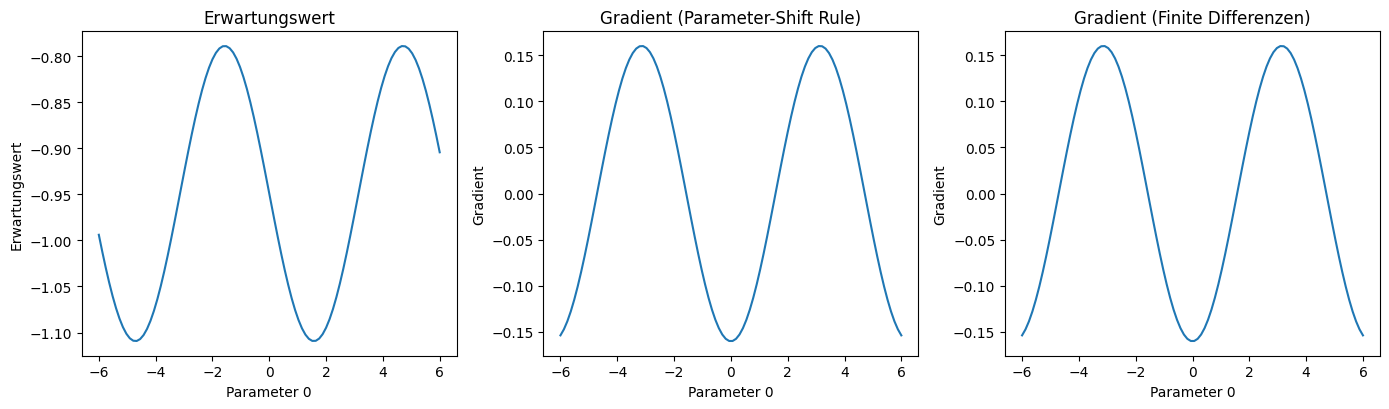

<module 'matplotlib.pyplot' from '/Users/davidkreplinhhn/Lehrveranstaltungen/Laborpraktikum QC WS 25/aqp_ws2526_work/.venv/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [25]:
plot()

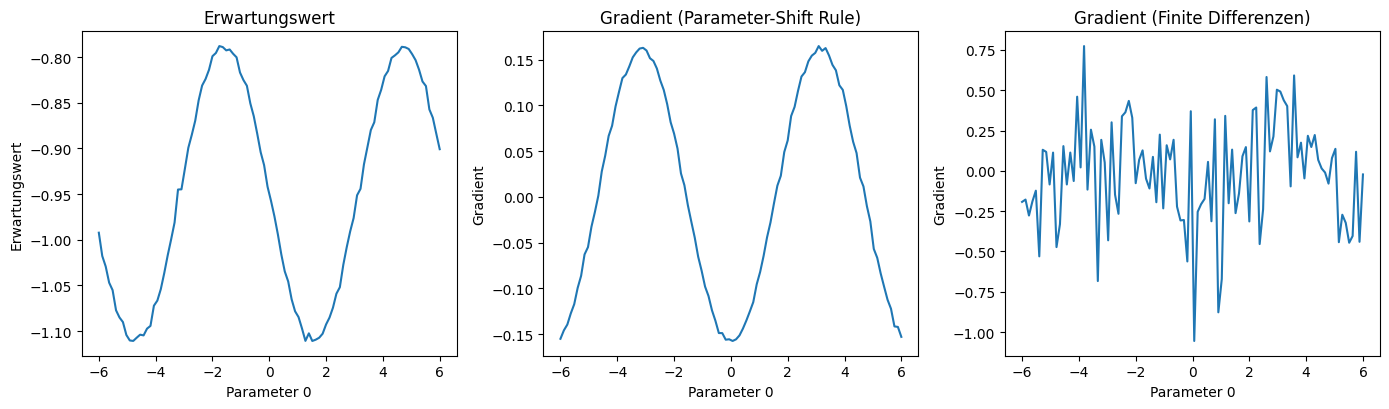

<module 'matplotlib.pyplot' from '/Users/davidkreplinhhn/Lehrveranstaltungen/Laborpraktikum QC WS 25/aqp_ws2526_work/.venv/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [26]:
plot(shots=1000)

**Beobachtung:** Die Gradientenberechnung mit finite Differenzen und Messungen funktioniert nicht mehr! 

### Aufgabe 4: Optimierung mit der Ableitung

Nun, da wir den Gradienten berechnen können, können wir diesen in die Optimierung integrieren.  
Ausgangspunkt ist die Implementierung der Optimierung **ohne** Gradienten aus Aufgabe 2.1 (Sie können den Code einfach kopieren und erweitern).


**Aufgabe 4.1:** Optimierung ohne Messfehler

Neben der Funktion `objective`, die wir minimieren und als Argument `fun` an `minimize` übergeben, benötigen wir nun zusätzlich eine Hilfsfunktion zur Gradientenberechnung.  
Verwenden Sie hierfür die **Parameter-Shift-Rule**:

```python
def gradient(parameters: np.ndarray) -> float:
    ...
    return gradient_parameter_shift_rule
```

Diese Funktion übergeben wir der `minimize`-Funktion über das Argument `jac=`.  
Zusätzlich wählen wir eine Optimierungsmethode, die Gradienten berücksichtigen kann.  
Hierfür verwenden wir die Methode `methond="SLSQP"`:

```python
result_optimization = minimize(
    fun=objective,
    x0=theta0,
    method="SLSQP",
    jac=gradient
)
```

Kopieren Sie ihren Code aus Aufgabe 2.1 und passen Sie ihn so an, dass die Optimierung mit dem Gradienten durchgeführt wird.
Wie viel Iterationen sind notwendig im Vergleich zu Aufgabe 2.1? 

In [27]:
quantum_circuit = parametrized_circuit(num_qubits=4, num_layers=3)

# Startwerte für die Parameter
np.random.seed(0)
theta0 = np.random.rand(quantum_circuit.num_parameters)

observable_h2 = SparsePauliOp(
    data=[
        "ZZIZ", "IZZI", "IIZI", "IIIZ", "IIII",
        "ZIZZ", "ZZZZ", "ZZII", "IZII", "IZZZ",
        "IIZZ", "IIII", "IIXX", "IZYY", "ZZYY",
        "ZIXX",
    ],
    coeffs=[
        0.0934565 + 0.0j, 0.0934565 + 0.0j, -0.03564482 + 0.0j, -0.03564482 + 0.0j, -0.84457058 + 0.0j,
        0.13817585 + 0.0j, 0.08253705 + 0.0j, 0.13992104 + 0.0j, 0.13992104 + 0.0j, 0.08253705 + 0.0j,
        0.14585519 + 0.0j, 0.35278481 + 0.0j, -0.05738398 + 0.0j, -0.05738398 + 0.0j, -0.05738398 + 0.0j,
        -0.05738398 + 0.0j,
    ],
)

In [28]:
def objective(parameters: np.ndarray) -> float:
    value = evaluate_expectation_value(quantum_circuit, observable_h2, parameters)
    print(value)
    return value


def gradient(parameters: np.ndarray) -> float:
    grad = gradient_parameter_shift_rule(quantum_circuit, observable_h2, parameters)
    return np.array(grad)


# Beispiel: Optimierung mit SLSQP
result_optimization = minimize(objective, x0=theta0, method="SLSQP", jac=gradient)

print("SLSQP:")
print(" theta* =", result_optimization.x)
print(" f(theta*) =", result_optimization.fun)
print(" nfev =", result_optimization.nfev)

-0.5367703021521458
-0.5968389893240028
-0.7538822477158167
-0.7952413425292717
-0.8296042156719351
-0.9060080557928085
-0.9449190002645113
-0.9575696464187159
-0.9653142049435185
-0.9677954849824814
-0.9744968839097461
-0.9786239724943758
-0.9854291708772479
-0.9895606314920316
-0.993747511657121
-0.9956701899339779
-0.9967674521418688
-0.9974641213262816
-0.9978857831268734
-0.998047143922576
-0.9981052671903817
-0.9981236463896286
-0.9981348045730155
-0.9981411672693415
-0.998144377916032
-0.9981468319712019
-0.9981484609215424
SLSQP:
 theta* = [ 1.05305411e-03  7.62986361e-01  3.78806136e-04  1.57123483e+00
  1.57114036e+00  1.57121704e+00  2.77336750e-01 -3.76503872e-01
 -1.11519595e-03 -3.95736249e-05  1.57263239e+00  2.58761391e-01]
 f(theta*) = -0.9981484609215424
 nfev = 27


**Aufgabe 4.2:** In der letzten Aufgabe untersuchen wir nun die Optimierung mit einer limitierten Anzahl von Messungen.  
Nehmen Sie den Code aus Aufgabe 4.1 und setzen Sie die Anzahl der Shots in den Funktionen `evaluate_expectation_value` und `gradient_parameter_shift_rule` auf `1000`.

Der in Aufgabe 4.1 verwendete Optimierer funktioniert mit dem Rauschen der Messwerte nicht zuverlässig (Sie können gerne ausprobieren, was passiert).  
Für diese Optimierung benötigen wir einen Optimierer, der robust gegenüber Rauschen ist.  
Wir verwenden hierfür den **ADAM-Optimierer**, der auch häufig zum Training klassischer neuronaler Netze eingesetzt wird.

Dieser kann aus der bereitgestellten Hilfsbibliothek importiert werden und wird anschließend ähnlich wie `minimize` verwendet.  
Das Argument `method=""` wird dabei **nicht** mehr benötigt.  
Die ADAM-Implementierung stoppt automatisch nach `100` Iterationen.

Was beobachten Sie für den optimierten Erwartungswert im Vergleich zu dem kleinsten Eigenwert?

In [29]:
from qc_lecture_tools.optimization import adam_minimize

quantum_circuit = parametrized_circuit(num_qubits=4, num_layers=3)

# Startwerte für die Parameter
np.random.seed(0)
theta0 = np.random.rand(quantum_circuit.num_parameters)
observable_h2 = SparsePauliOp(
    data=[
        "ZZIZ", "IZZI", "IIZI", "IIIZ", "IIII",
        "ZIZZ", "ZZZZ", "ZZII", "IZII", "IZZZ",
        "IIZZ", "IIII", "IIXX", "IZYY", "ZZYY",
        "ZIXX",
    ],
    coeffs=[
        0.0934565 + 0.0j, 0.0934565 + 0.0j, -0.03564482 + 0.0j, -0.03564482 + 0.0j, -0.84457058 + 0.0j,
        0.13817585 + 0.0j, 0.08253705 + 0.0j, 0.13992104 + 0.0j, 0.13992104 + 0.0j, 0.08253705 + 0.0j,
        0.14585519 + 0.0j, 0.35278481 + 0.0j, -0.05738398 + 0.0j, -0.05738398 + 0.0j, -0.05738398 + 0.0j,
        -0.05738398 + 0.0j,
    ],
)

In [30]:
def objective(parameters: np.ndarray) -> float:
    value = evaluate_expectation_value(
        quantum_circuit, observable_h2, parameters, shots=1000
    )
    print(value)
    return value


def gradient(parameters: np.ndarray) -> float:
    grad = gradient_parameter_shift_rule(
        quantum_circuit, observable_h2, parameters, shots=1000
    )
    return np.array(grad)


# Beispiel: Optimierung mit ADAM
result_optimization = adam_minimize(objective, x0=theta0, jac=gradient)

print("ADAM:")
print(" theta* =", result_optimization.x)
print(" f(theta*) =", result_optimization.fun)
print(" nfev =", result_optimization.nfev)

-0.5250040446253746
-0.5668917625074925
-0.6013112098201796
-0.6542508408691308
-0.7520643876023976
-0.7679222333566432
-0.8511872686813187
-0.8915572552147852
-0.907792265884116
-0.9495398554945054
-0.952797522187812
-0.9478626064235764
-0.9431570636863136
-0.9388441596703296
-0.9637429966333666
-0.9463079572327673
-0.9577147278221777
-0.9583767151548451
-0.9641685602697303
-0.9727455878021979
-0.964180797032967
-0.9708692006293707
-0.9740642842657342
-0.96839960014985
-0.9827279645454545
-0.9882456672427572
-0.9865368198901099
-0.9836633297002997
-0.9836817975124876
-0.9854325002497502
-0.9779271009690308
-0.9851819290209789
-0.9982113705794204
-0.9866626087012986
-0.9838251512387614
-0.9908819917982019
-0.9924737622677324
-1.0035226207692307
-0.9861459234665335
-0.9945689186713287
-0.9901587141158841
-0.9920933538761239
-0.9834823258241758
-0.9921554972127873
-0.9942673777322675
-1.001005728141858
-0.995076276993007
-0.9909582017482517
-1.0002887872827173
-1.0044932254445555
-0.9930

**Beobachtung:** Der kleinste Erwartungswert kann niedriger werden als der kleinste Eigenwert der Observable, wenn mit Messungen gearbeitet wird.Dies liegt daran, dass die Messungen statistische Schwankungen aufweisen, die zu einer Unterschätzung des Erwartungswerts führen können. 